In [ ]:
#This code was written to finetune BERT to identify hedges (binary classification), finetuning on one domain and testing on another.
!pip install datasets evaluate transformers[torch] accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2
ERROR: pip's dep

In [ ]:
from google.colab import drive
import numpy as np
from transformers import AutoModelForSequenceClassification
import pandas as pd
import os
from datasets import load_dataset, Dataset
from sklearn.model_selection import KFold
from transformers import AutoModel, AutoTokenizer
import evaluate
from transformers import TrainingArguments, Trainer, TrainerCallback
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

In [ ]:

drive.mount('/content/drive')

In [ ]:
%cd /content/your_directory

/content/drive/MyDrive/Saarbrücken/Masterarbeit/final/DE


In [ ]:
# Load dataset a
ds_a = load_dataset('csv', data_files="dataset_a.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
print(ds_a)

DatasetDict({
    train: Dataset({
        features: ['text_id', 'text', 'label', 'modal'],
        num_rows: 1452
    })
})


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
#or tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

In [ ]:
#define tokenizer function
def tokenize_function(examples):
  return tokenizer(
      examples["text"], padding="max_length", truncation=True
  )

In [ ]:
#tokenize dataset
tokenized_dataset_a = ds_a.map(
    tokenize_function, batched=True
)

Map:   0%|          | 0/1452 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_dataset_a)


DatasetDict({
    train: Dataset({
        features: ['text_id', 'text', 'label', 'modal', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1452
    })
})


In [ ]:
#make dataframe
dataseta2 = tokenized_dataset_a['train']
df_a = dataseta2.to_pandas()

NameError: name 'tokenized_dataset_a' is not defined

In [ ]:
print(df_a.head())
print(df_a.columns)

                text_id                                               text  \
0  text_id SI_EN_DE_082  Dieses Packet zeigt wenn der Lissaboner Vertra...   
1  text_id SI_EN_DE_079  Frau Dahl hat einmal vorgeschlagen dass bestim...   
2  text_id SI_EN_DE_088  Frau Kommissarin ich möchte jetzt Klartext spr...   
3  text_id SI_EN_DE_046  Frau Präsidentin Frau Kommissarin wir müssen e...   
4  text_id SI_EN_DE_114  Geld Trinkwasser Strom und dann muss die Wirts...   

   label   modal                                          input_ids  \
0      0  werden  [102, 3077, 13910, 172, 2652, 684, 125, 13944,...   
1      0  werden  [102, 898, 24255, 308, 1839, 7834, 377, 4900, ...   
2      0   mögen  [102, 898, 12229, 113, 383, 2298, 1184, 7581, ...   
3      0  müssen  [102, 898, 11440, 898, 12229, 113, 268, 1128, ...   
4      0  müssen  [102, 1904, 17475, 4621, 136, 742, 1092, 128, ...   

                                      token_type_ids  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
  #Split kfolds and make folder to save models in
  n=5
  kf = KFold(n_splits=n, random_state=42, shuffle=True)
  model_save_dir = "./directory_for_saving_models"
  os.makedirs(model_save_dir, exist_ok=True)

In [ ]:
print(kf)

KFold(n_splits=5, random_state=42, shuffle=True)


In [ ]:
#load accuracy, f1, recall, and mcc and store in variable
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")
matthews_metric = evaluate.load("matthews_correlation")
precision_metric = evaluate.load("precision")


ModuleNotFoundError: No module named 'evaluate'

In [ ]:
#define compute metrics
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  # store accuracy, f1 and recall and store in variables
  accuracy = accuracy_metric.compute(predictions=predictions, references=labels)['accuracy']
  f1 = f1_metric.compute(predictions=predictions, references=labels)['f1']
  recall = recall_metric.compute(predictions=predictions, references=labels)['recall']
  precision = precision_metric.compute(predictions=predictions, references=labels)['precision']
  mcc = matthews_metric.compute(predictions=predictions, references=labels)['matthews_correlation']
  #tell the computer you want each metric and that you want it labeled accordingly
  return {
        'accuracy': accuracy,
        'f1': f1,
        'recall': recall,
        'precision': precision,
        'mcc': mcc
        }

In [ ]:
#save training metric logs
class DetailedTrainingLogger(TrainerCallback):
    def __init__(self, trainer, eval_dataset):
        self.logs = []
        self.trainer = trainer
        self.eval_dataset = eval_dataset

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Access logs directly without disrupting default behavior
        if logs:
            logs_entry = {
                "Step": state.global_step,
                "Training Loss": logs.get("loss", "No log"),
                "Validation Loss": logs.get("eval_loss", None),
                "Accuracy": logs.get("eval_accuracy", None),
                "F1": logs.get("eval_f1", None),
                "Recall": logs.get("eval_recall", None),
                "Precision": logs.get("eval_precision", None),
                "MCC": logs.get("eval_mcc", None),
            }
            self.logs.append(logs_entry)




In [ ]:
#define training arguments; adjust as needed
training_args = TrainingArguments(
    output_dir="bert_trainer",
    run_name='name',
    evaluation_strategy="steps",
    eval_steps=50, logging_steps=10,
    per_device_train_batch_size=32,
    num_train_epochs=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    report_to="none",
    save_steps=50,
    seed=42
    )

NameError: name 'TrainingArguments' is not defined

In [ ]:
#create a metrics dataframe to save metrics info later
metrics_df = pd.DataFrame(columns=['fold', 'accuracy', 'f1', 'recall', 'precision', 'mcc'])

In [ ]:
#make metrics list
metrics_list = []

In [ ]:
#make list to fill with incorrectly predicted sentences
incorrect_list = []

In [ ]:
#create list to store logs
all_logs = []

In [ ]:
fold_num = 1  # Initialize fold counter

# Initialize lists to accumulate predictions and true labels from all folds
all_predictions = []
all_true_labels = []

for train_index, val_index in kf.split(df_a):
    model = AutoModelForSequenceClassification.from_pretrained("dbmdz/bert-base-german-cased", num_labels=2)
    #or model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2) or other model
    #send to gpu
    model.to("cuda")

    # splitting Dataframe
    train_df = df_a.iloc[train_index]
    val_df = df_a.iloc[val_index]

    # Convert back into dataset for trainer
    train_dataset = Dataset.from_pandas(train_df)
    eval_dataset = Dataset.from_pandas(val_df)

    # Training arguments
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
    )
    # Create DetailedTrainingLogger with the trainer and eval_dataset
    detailed_logger = DetailedTrainingLogger(trainer, eval_dataset)

    # Add the logger to the trainer's callbacks
    trainer.add_callback(detailed_logger)

    trainer.train()

    # Add logs to the aggregated list, including fold number
    for log in detailed_logger.logs:
        log["Fold"] = fold_num
        all_logs.append(log)

    #Save model
    model_directory =f"{model_save_dir}/model_directory_{fold_num}"
    model.save_pretrained(model_directory)

    # Evaluate
    eval_results = trainer.evaluate()

    # Get predictions
    outputs = trainer.predict(eval_dataset)
    predictions = np.argmax(outputs.predictions, axis=1)
    true_labels = np.array(eval_dataset['label'])

    # Accumulate predictions and true labels
    all_predictions.extend(predictions)
    all_true_labels.extend(true_labels)


    # Collect metrics
    metrics = compute_metrics((outputs.predictions, eval_dataset['label']))

    selected_metrics = {
    'Fold': fold_num,
    'accuracy': metrics.get('accuracy', None),
    'f1': metrics.get('f1', None),
    'recall': metrics.get('recall', None),
    'precision': metrics.get('precision', None),
    'mcc': metrics.get('mcc', None)
}
    metrics_list.append(selected_metrics)

    # Increase fold count
    fold_num += 1

    # Identify misclassified examples
    misclassified_indices = np.where(predictions != true_labels)[0]
    misclassified_examples = val_df.iloc[misclassified_indices]

    # Print misclassified examples
    if len(misclassified_indices) > 0:
        for idx in range(len(misclassified_examples)):
            incorrect = {
                'text id': misclassified_examples.iloc[idx]['text id'],
                'text': misclassified_examples.iloc[idx]['text'],
                'True Label': true_labels[misclassified_indices[idx]],
                'Prediction': predictions[misclassified_indices[idx]]
            }
            incorrect_list.append(incorrect)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision,Mcc
10,0.350800,0.293000,0.914089,0.000000,0.000000,0.000000,0.000000
20,0.248800,0.298893,0.914089,0.000000,0.000000,0.000000,0.000000
30,0.297000,0.285963,0.914089,0.000000,0.000000,0.000000,0.000000
40,0.235200,0.254434,0.914089,0.000000,0.000000,0.000000,0.000000
50,0.187600,0.224987,0.924399,0.352941,0.240000,0.666667,0.370231
60,0.167500,0.212785,0.931271,0.411765,0.280000,0.777778,0.441064
70,0.237800,0.212466,0.927835,0.400000,0.280000,0.700000,0.413391
80,0.169700,0.238719,0.931271,0.444444,0.320000,0.727273,0.453631
90,0.108000,0.323701,0.903780,0.481481,0.520000,0.448276,0.430207
100,0.126000,0.274590,0.934708,0.424242,0.280000,0.875000,0.473435


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision,Mcc
10,0.411200,0.298631,0.917526,0.000000,0.000000,0.000000,0.000000
20,0.308800,0.286129,0.917526,0.000000,0.000000,0.000000,0.000000
30,0.287000,0.282297,0.917526,0.000000,0.000000,0.000000,0.000000
40,0.210800,0.303727,0.917526,0.000000,0.000000,0.000000,0.000000
50,0.312700,0.282848,0.917526,0.000000,0.000000,0.000000,0.000000
60,0.293100,0.269832,0.917526,0.000000,0.000000,0.000000,0.000000
70,0.266400,0.242902,0.917526,0.000000,0.000000,0.000000,0.000000
80,0.180700,0.249628,0.917526,0.000000,0.000000,0.000000,0.000000
90,0.209600,0.241677,0.924399,0.214286,0.125000,0.750000,0.286476
100,0.219200,0.363901,0.838488,0.471910,0.875000,0.323077,0.469067


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision,Mcc
10,0.384500,0.289809,0.920690,0.000000,0.000000,0.000000,0.000000
20,0.253100,0.282262,0.920690,0.000000,0.000000,0.000000,0.000000
30,0.254800,0.291074,0.920690,0.000000,0.000000,0.000000,0.000000
40,0.347600,0.275885,0.920690,0.000000,0.000000,0.000000,0.000000
50,0.220900,0.278582,0.920690,0.000000,0.000000,0.000000,0.000000
60,0.282200,0.277123,0.920690,0.000000,0.000000,0.000000,0.000000
70,0.336500,0.290694,0.920690,0.000000,0.000000,0.000000,0.000000
80,0.296800,0.282783,0.920690,0.000000,0.000000,0.000000,0.000000
90,0.249900,0.228747,0.920690,0.000000,0.000000,0.000000,0.000000
100,0.213800,0.260269,0.920690,0.000000,0.000000,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision,Mcc
10,0.348900,0.353633,0.910345,0.000000,0.000000,0.000000,0.000000
20,0.325000,0.338378,0.910345,0.000000,0.000000,0.000000,0.000000
30,0.272900,0.331005,0.910345,0.000000,0.000000,0.000000,0.000000
40,0.257300,0.305721,0.910345,0.000000,0.000000,0.000000,0.000000
50,0.235700,0.310803,0.910345,0.000000,0.000000,0.000000,0.000000
60,0.331000,0.303573,0.910345,0.000000,0.000000,0.000000,0.000000
70,0.295900,0.291730,0.910345,0.000000,0.000000,0.000000,0.000000
80,0.215600,0.271650,0.910345,0.000000,0.000000,0.000000,0.000000
90,0.222200,0.255712,0.910345,0.000000,0.000000,0.000000,0.000000
100,0.268200,0.313588,0.837931,0.419753,0.653846,0.309091,0.371590


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision,Mcc
10,0.420100,0.249848,0.937931,0.000000,0.000000,0.000000,0.000000
20,0.336800,0.231214,0.937931,0.000000,0.000000,0.000000,0.000000
30,0.238300,0.252157,0.937931,0.000000,0.000000,0.000000,0.000000
40,0.310500,0.244750,0.937931,0.000000,0.000000,0.000000,0.000000
50,0.218300,0.236067,0.937931,0.000000,0.000000,0.000000,0.000000
60,0.254600,0.316686,0.855172,0.160000,0.222222,0.125000,0.091856
70,0.274900,0.280947,0.937931,0.000000,0.000000,0.000000,0.000000
80,0.253500,0.215432,0.944828,0.500000,0.444444,0.571429,0.475457
90,0.190200,0.212327,0.934483,0.486486,0.500000,0.473684,0.451711
100,0.196500,0.248446,0.944828,0.200000,0.111111,1.000000,0.323942


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

In [ ]:
# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics_list)
# Save to CSV
csv_file_path = '/content/drive/your_metrics_folder/name.csv'
metrics_df.to_csv(csv_file_path, index=False)
print(f'Metrics saved to {csv_file_path}')


Metrics saved to /content/drive/MyDrive/Saarbrücken/Masterarbeit/final/DE/Interp_trained/metrics_DE_interp.csv


In [ ]:
# Create dataframe of training logs and save
training_log_df = pd.DataFrame(all_logs)
log_csv_path = '/content/drive/your_metrics_folder/training_log.csv'
training_log_df.to_csv(log_csv_path, index=False)

In [ ]:
# Calculate mean and standard deviation for each metric across folds
metrics_mean = metrics_df.mean()
metrics_std = metrics_df.std()

# Add mean and std to the DataFrame for reference
summary_df = pd.DataFrame({
    'metric': metrics_mean.index,
    'mean': metrics_mean.values,
    'std': metrics_std.values
})

# Save the summary of mean and std
summary_csv_path = '/content/drive/your_metrics_folder/metrics_summary.csv'
summary_df.to_csv(summary_csv_path, index=False)

print(f'Metrics saved to {csv_file_path}')
print(f'Summary of mean and std saved to {summary_csv_path}')

Metrics saved to /content/drive/MyDrive/Saarbrücken/Masterarbeit/final/DE/Interp_trained/metrics_DE_interp.csv
Summary of mean and std saved to /content/drive/MyDrive/Saarbrücken/Masterarbeit/final/DE/Interp_trained/metrics_summary_DE_interp.csv


In [ ]:
sentences_df = pd.DataFrame(columns=['text id','text', 'true label', 'prediction',])

In [ ]:
# Convert sentences, labels and predictions to DataFrame
sentences_df = pd.DataFrame(incorrect_list)
# Save to CSV
csv_file_path = '/content/drive/your_metrics_folder/incorrect_sentences.csv'
sentences_df.to_csv(csv_file_path, index=False)
print(f'Sentences saved to {csv_file_path}')

Sentences saved to /content/drive/MyDrive/Saarbrücken/Masterarbeit/final/DE/Interp_trained/sentences_DE_interp.csv


Confusion matrix saved to /content/drive/MyDrive/Saarbrücken/Masterarbeit/final/DE/Interp_trained/matrix_DE_interp.csv
Heatmap saved to /content/drive/MyDrive/Saarbrücken/Masterarbeit/final/DE/Interp_trained/heatmap_EN_interp.png


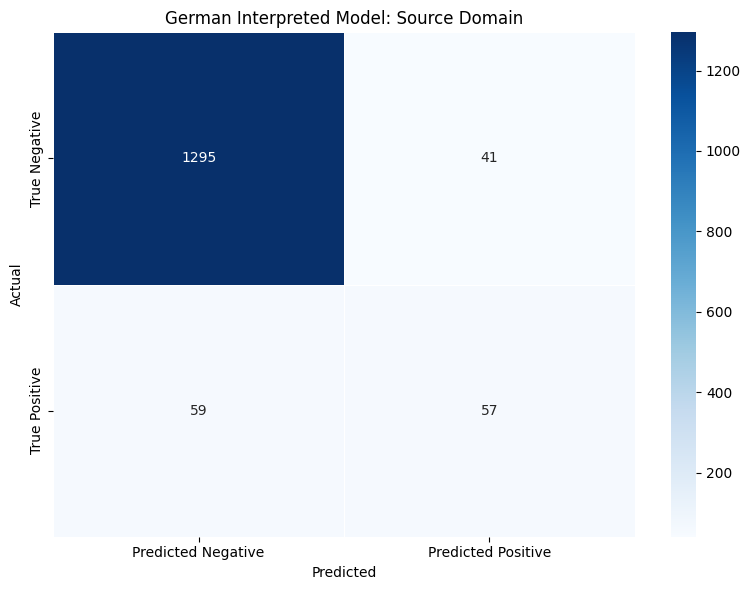

In [ ]:

# Turn predictions into numpy array and store in variable
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Generate the confusion matrix
overall_cm = confusion_matrix(all_true_labels, all_predictions)

# Convert the confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(overall_cm,
                     index=['True Negative', 'True Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])

# Save the confusion matrix to a CSV file
csv_file_path = '/content/drive/your_metrics_folder/matrix_dataseta.csv'
cm_df.to_csv(csv_file_path)
print(f"Confusion matrix saved to {csv_file_path}")

# Plot the heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(cm_df,
            annot=True,           # Annotate each cell with the numeric value
            fmt='d',              # Format for integer numbers
            cmap='Blues',         # Color map for the heatmap
            linewidths=0.5,       # Line widths between cells
            linecolor='white')    # Line color between cells

# Add labels and title
plt.title("Your Title")
plt.ylabel("Actual")
plt.xlabel("Predicted")


# Save the heatmap as an image file
heatmap_file_path = '/content/drive/your_metrics_folder/heatmap_dataseta.png'
plt.tight_layout()  # Adjust layout to avoid clipping of labels
plt.savefig(heatmap_file_path, dpi=300, bbox_inches='tight')  # Save the plot
print(f"Heatmap saved to {heatmap_file_path}")

# Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping of labels
plt.show()


In [ ]:
#load second dataset
ds_b= load_dataset('csv', data_files="datasetb.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
print(ds_b)

DatasetDict({
    train: Dataset({
        features: ['text_id', 'text', 'label', 'modal'],
        num_rows: 1187
    })
})


In [ ]:
#tokenize second dataset
tokenized_dataset_b = ds_b.map(
    tokenize_function, batched=True
)

Map:   0%|          | 0/1187 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_dataset_b)

DatasetDict({
    train: Dataset({
        features: ['text_id', 'text', 'label', 'modal', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1187
    })
})


In [ ]:
#Create dataframe
dataset_b_2 = tokenized_dataset_b['train']
df_b = dataset_b_2.to_pandas()

In [ ]:
#Shuffle data
df_b = shuffle(df_b, random_state=42).reset_index(drop=True)

In [ ]:
#create metrics dataframe
metrics_df_b = pd.DataFrame(columns=['fold', 'accuracy', 'f1', 'recall', 'precision', 'mcc'])

In [ ]:
#make metrics list
metrics_list_b = []

In [ ]:
#create list for incorrectly predicted sentences
incorrect_list_b = []

In [ ]:
#new "training" arguments- set training to no
training_argsb = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="no",
    save_strategy="no",
    do_train=False,
    report_to="none",
    disable_tqdm=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
os.environ["WANDB_DISABLED"] = "true"  # Disable W&B for the current session


# Accumulate predictions and true labels across folds
all_predictions_b = []
all_true_labels_b = []

for fold_num in range(1, 6):  # Loop through each saved model (5 folds)
    # Load the saved model
    model_directory = f"{model_save_dir}/model_directory_{fold_num}"
    model = AutoModelForSequenceClassification.from_pretrained(model_directory, num_labels=2)
    #send to gpu
    model.to("cuda")

    # Initialize Trainer for evaluation
    trainer = Trainer(
        model=model,
        args=training_argsb,
        eval_dataset=dataset_b_2,
        compute_metrics=compute_metrics,
    )

    # Evaluate the model
    eval_results = trainer.evaluate()

    # Predict on Dataset B
    outputs = trainer.predict(dataset_b_2)
    predictions = np.argmax(outputs.predictions, axis=1)
    true_labels = dataset_b_2['label']

    # Accumulate predictions and true labels
    all_predictions_b.extend(predictions)
    all_true_labels_b.extend(true_labels)

    # Store evaluation metrics
    selected_metrics = {
        'Fold': fold_num,
        'accuracy': eval_results.get('eval_accuracy', None),
        'f1': eval_results.get('eval_f1', None),
        'recall': eval_results.get('eval_recall', None),
        'precision': eval_results.get('eval_precision', None),
        'mcc': eval_results.get('eval_mcc', None),
    }
    metrics_list_b.append(selected_metrics)

    # Identify misclassified examples
    misclassified_indices = np.where(predictions != true_labels)[0]
    for idx in misclassified_indices:
          # Explicitly convert idx to a Python int
          idx = int(idx)
          incorrect = {
              'column 1': dataset_b_2[idx]['column 1'],
              'column 2': dataset_b_2[idx]['column 2'],
              'True Label': true_labels[idx],
              'Prediction': predictions[idx],
              }
          incorrect_list_b.append(incorrect)

In [ ]:
# Convert metrics to DataFrame
metrics_df_b = pd.DataFrame(metrics_list_b)
# Save to CSV
csv_file_path = '/content/drive/your_metrics_folder/metrics_datasetb.csv'
metrics_df_b.to_csv(csv_file_path, index=False)
print(f'Metrics saved to {csv_file_path}')

Metrics saved to /content/drive/MyDrive/Saarbrücken/Masterarbeit/final/DE/Interp_trained/metrics_DE_interporgswitch.csv


In [ ]:
# Calculate mean and standard deviation for each metric across folds
metrics_mean_b = metrics_df_b.mean()
metrics_std_b = metrics_df_b.std()

# Add mean and std to the DataFrame for reference
summary_df_b = pd.DataFrame({
    'metric': metrics_mean_b.index,
    'mean': metrics_mean_b.values,
    'std': metrics_std_b.values
})

# Save the summary of mean and std
summary_csv_path = '/content/drive/your_metrix_folder/metrics_summary_datasetb.csv'
summary_df_b.to_csv(summary_csv_path, index=False)

print(f'Metrics saved to {csv_file_path}')
print(f'Summary of mean and std saved to {summary_csv_path}')

Metrics saved to /content/drive/MyDrive/Saarbrücken/Masterarbeit/final/DE/Interp_trained/metrics_DE_interporgswitch.csv
Summary of mean and std saved to /content/drive/MyDrive/Saarbrücken/Masterarbeit/final/DE/Interp_trained/metrics_summary_DE_interporgswitch.csv


In [ ]:
sentences_df = pd.DataFrame(columns=['text id','text', 'true label', 'prediction',])

In [ ]:
# Convert sentences, labels and predictions to DataFrame
sentences_df_b = pd.DataFrame(incorrect_list_b)
# Save to CSV
csv_file_path = '/content/drive/your_metrics_folder/misidentified_sentences_datsetb.csv'
sentences_df_b.to_csv(csv_file_path, index=False)
print(f'Sentences saved to {csv_file_path}')

Sentences saved to /content/drive/MyDrive/Saarbrücken/Masterarbeit/final/DE/Interp_trained/sentences_DE_interporgswitch.csv


Confusion matrix saved to /content/drive/MyDrive/Saarbrücken/Masterarbeit/final/DE/Interp_trained/matrix_DE_interporgswitch.csv


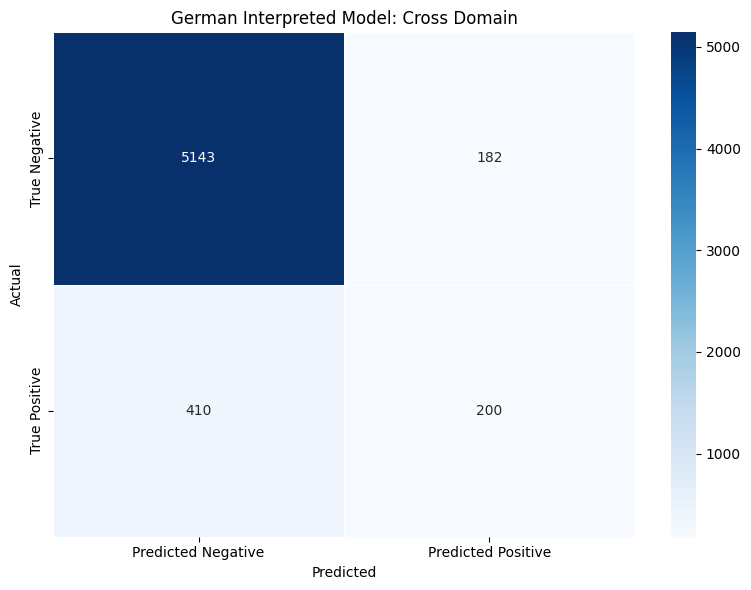

In [ ]:
# Create array from predictions and labels
all_predictions_b = np.array(all_predictions_b)
all_true_labels_b = np.array(all_true_labels_b)

# Generate the confusion matrix
overall_cmb = confusion_matrix(all_true_labels_b, all_predictions_b)

# Convert the confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(overall_cmb,
                     index=['True Negative', 'True Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])

# Save the confusion matrix to a CSV file
csv_file_path = '/content/drive/your_metrics_folder/matrix_dtasetb.csv'
cm_df.to_csv(csv_file_path)
print(f"Confusion matrix saved to {csv_file_path}")

# Plot the heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(cm_df,
            annot=True,           # Annotate each cell with the numeric value
            fmt='d',              # Format for integer numbers
            cmap='Blues',         # Color map for the heatmap
            linewidths=0.5,       # Line widths between cells
            linecolor='white')    # Line color between cells

# Add labels and title
plt.title("Dataset B")
plt.ylabel("Actual")
plt.xlabel("Predicted")

# Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping of labels
plt.show()
